# Content

This notebook contains the simulation of the 2D ion crystal consisting of 3 ions and calculation of its normal modes.

The normal modes are calculated with *sion.normal_modes()* function. The normal modes are verified through the calculation of the fast Fourier transform (FFT) of the simulated ion trajectories. The method comes as follows:
1. Calculate equilibrium ion positions from the simulation with cooling.
2. Calculate normal modes of the resulting crystal by *sion.normal_modes()*.
3. Perform simulation of ion crystal without cooling, with starting ion positions being pushed by random small kick from the equilibrium. 
4. Transform coordinates of 3 ions into coordinates of 9 normal modes, using the normal mode vectors, obtained previously.
5. Calculate FFT on these normal coordinates.

The resulting function should possess a peak close to the frequency of the normal mode, calculated by *sion*.

In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
                       PointPixelElectrode, PotentialObjective,
                       PatternRangeConstraint, shaped)
import sion as sn




## Trap defiinition

Trap with high enough anisotropy parameter $\alpha = \omega_x^2/\omega_y^2$ for the 2D crystal of 3 ions. 

[9.02933556e-25 6.99984482e-05 1.37037894e-04]
Potential minimum: (5.77e-16, 70, 137) mkm
Secular frequencies: (1.226, 1.388, 3.048) MHz
In directions  [[ 1.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -1.15361735e-16]
 [ 0.00000000e+00  3.68932155e-17  1.00000000e+00]]
Anisotropy parameter: 0.78
Anharmonic scale length in y-direction
l2 = 3.5745224433726983e-06 
l3 = 141232902539.58563 
l4 = -3.439222078672967e-05


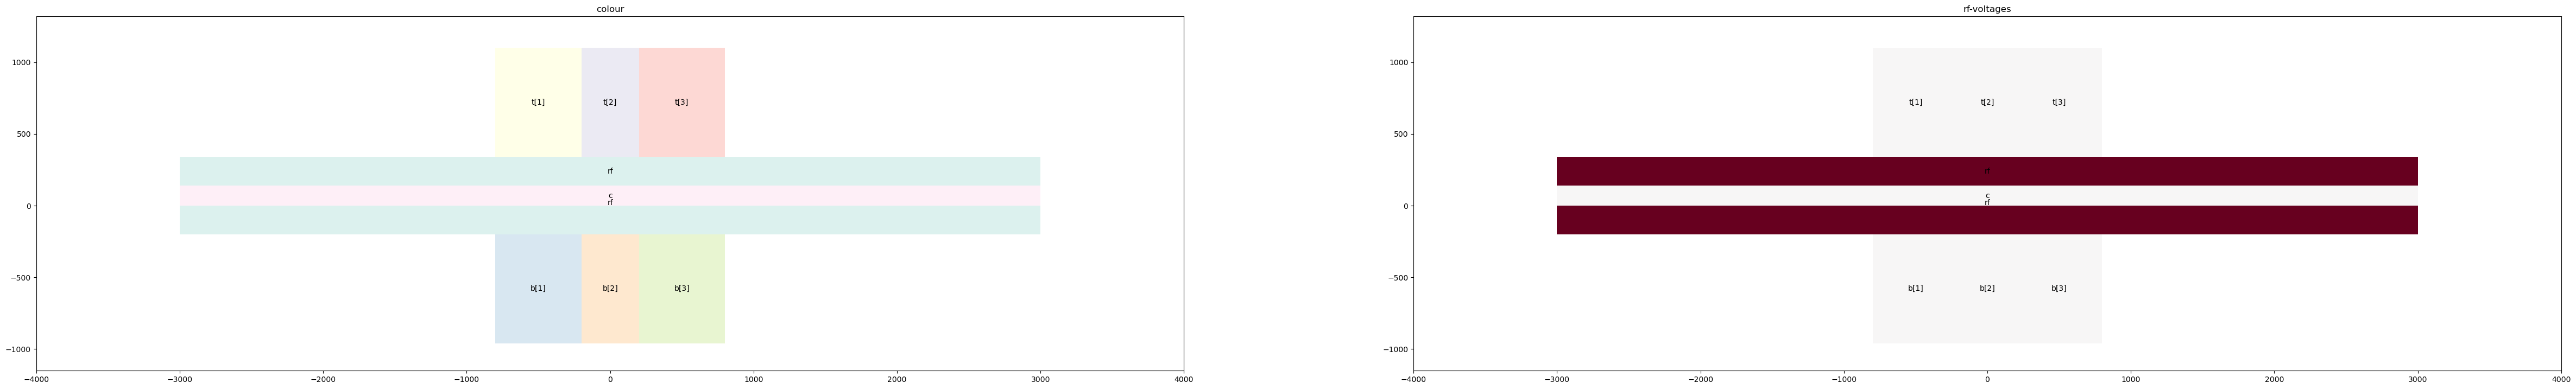

In [2]:
# Global definition of trap parameters.
L = 1e-6 # length scale
Vrf = 155 # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*43e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
DCtop = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 140  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 200  # width of top rf electrode, not including width of central electrode
rflength = 6000  # length of rf electrodes
rfbottom = 200  # width of bottom rf electrode
patternTop = 1  # number of groups of Top dc electrodes, defined in DCtop. if None then = 1
patternBot = 1  # same for bottom dcs
getCoordinate = None  # If not None, writes a file with coordinates of vertexes of electrodes
gapped = 0  # gaps between central DC electrode and RF lines
cheight = 1000  # height of the grounded cover electrode plane
cmax = 0  # order of the expansion of cover potential. if 0 - coder not considered, if 5 - considered with optimal precision
plot = 1

elec, Numb, sist = sn.FiveWireTrap(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, patternTop, patternBot, getCoordinate, gapped, cheight, cmax, plot)

x0 = L*np.array(sist.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
print(x0)
u_set = np.array([0, 15, -15, 15, 15, -15, 15, 1.4])
# routine to find secular frequencies in minimum point
with sist.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x = sist.minimum((0., 70, 120), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('Potential minimum: (%.3g, %.3g, %.3g) mkm' % (x[0], x[1], x[2]))

    # Get trap frequencies
    try:
        curv_z, mod_dir = sist.modes(x, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        print("In directions ", mod_dir)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6
x0 = x*1e-6

with sist.with_voltages(dcs = u_set, rfs = None):
    scales = sn.anharmonics(sist, [x], 1, L)
    
scales = scales[0]
print('Anharmonic scale length in y-direction\nl2 =', scales[0], '\nl3 =', scales[1], '\nl4 =', scales[2])



## Equilibrium ion positions

The simulation of 3 ions is performed in the presence of cooling, to obtain their equilibrium positions.

Reducing timestep to 1.8506388731615735e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  3 settings made for charge
3 atoms in group 1
3 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 1.85064e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0   

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Final positions of ions in mkm:
 [[-2.95e+00  7.14e+01  1.37e+02]
 [-2.21e-11  6.72e+01  1.37e+02]
 [ 2.95e+00  7.14e+01  1.37e+02]]


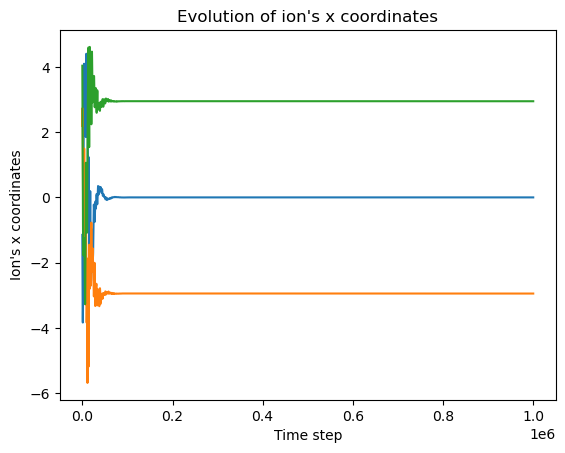

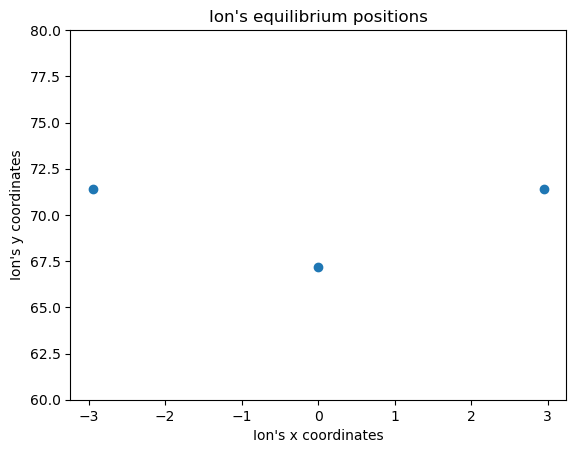

In [3]:

ion_number = 3
x0 = x*1e-6

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x0, ion_number, 10e-6)
s.append(pl.placeions(ions, positions))

#declaration of a five wire trap
s.append(sn.five_wire_trap(Omega, Vrf, u_set, elec, Numb, [cmax, cheight]))

#temperature initialization
s.append(pl.thermalvelocities(5, False))

#cooling simulation
s.append(pl.langevinbath(0, 1e-6))

#files with simulation information
s.append(pl.dump('2Dpositions3_eq.txt', variables=['x', 'y', 'z'], steps=10))
s.append(pl.evolve(1e6))
s.execute()

_, data = pl.readdump('2Dpositions3_eq.txt')
data *= 1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

np.set_printoptions(2)
print('Final positions of ions in mkm:\n', ion_positions)


plt.figure()
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([60, 80])
plt.show()


## Ion crystal normal modes

For this 2D crystal we calculate normal mode vectors and their frequencies. 

Final positions of ions in mkm:
 [[-2.95e+00  7.14e+01  1.37e+02]
 [-2.21e-11  6.72e+01  1.37e+02]
 [ 2.95e+00  7.14e+01  1.37e+02]]
Normal mode frequencies: [ 171427.15 1226096.99 1387936.64 1399236.5  1773874.78 2266393.19
 2716128.68 2791443.68 3047996.78]
Normal modes: [[ 3.01e-01 -6.01e-01  3.01e-01  4.78e-01 -4.48e-13 -4.78e-01 -2.72e-04
  -6.28e-15  2.72e-04]
 [-5.77e-01 -5.77e-01 -5.77e-01  3.55e-16 -1.61e-16 -2.33e-16  3.29e-17
  -2.40e-17  9.06e-20]
 [ 5.79e-15  1.52e-16 -5.71e-15  5.77e-01  5.77e-01  5.77e-01  2.45e-16
   8.07e-17 -1.56e-16]
 [-5.51e-01  6.25e-12  5.51e-01 -2.56e-01  5.12e-01 -2.56e-01 -1.02e-03
   2.04e-03 -1.02e-03]
 [-2.76e-01  5.52e-01 -2.76e-01  5.21e-01 -2.85e-12 -5.21e-01  3.37e-03
  -4.37e-14 -3.37e-03]
 [ 4.43e-01 -2.98e-12 -4.43e-01 -3.18e-01  6.36e-01 -3.18e-01 -8.06e-03
   1.61e-02 -8.06e-03]
 [ 7.38e-03 -1.24e-13 -7.38e-03 -6.91e-03  1.38e-02 -6.91e-03  4.08e-01
  -8.16e-01  4.08e-01]
 [ 1.43e-03 -2.87e-03  1.43e-03 -2.30e-03 -1.29e-13  2.30e-03

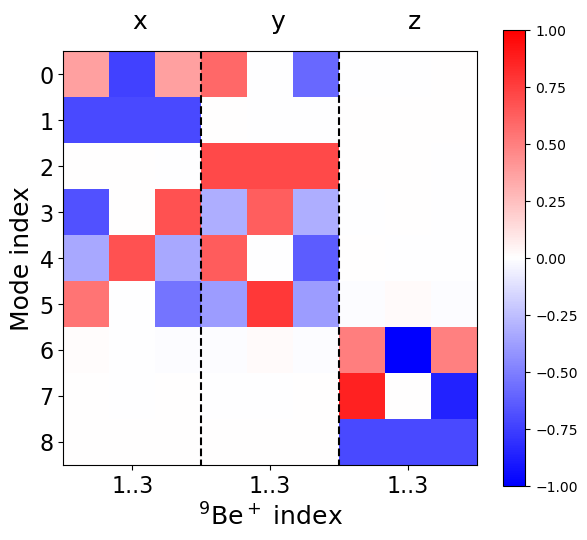

In [14]:
ion_number = 3
_, data = pl.readdump('2Dpositions3_eq.txt')
data *= 1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

np.set_printoptions(2)
print('Final positions of ions in mkm:\n', ion_positions)
ion_masses = [mass for el in range(ion_number)]
omegas = [omega_sec for el in range(ion_number)]
ion_positions_new = ion_positions*L

#obtaining normal modes, for general case
freqs, modes = sn.normal_modes(ion_positions_new, omegas, ion_masses)
print("Normal mode frequencies:", freqs)
print("Normal modes:", modes)

plt.figure(figsize = [6, 6])
plt.imshow(modes[:,:] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
plt.colorbar(shrink = 0.8)
plt.tight_layout()
plt.vlines([2.5,5.5], ymin = -0.5, ymax = 8.5 ,linestyles = 'dashed', color = 'k')
plt.locator_params(axis='x', nbins=3)
plt.text(1, -1,'x', fontsize = 18)
plt.text(4,-1,'y',fontsize = 18)
plt.text(7, -1,'z',fontsize = 18)
plt.xlabel('$^{9}$Be$^+$ index', fontsize = 18)
plt.ylabel('Mode index', fontsize = 18)
plt.xticks([1, 4, 7],['1..3', '1..3', '1..3'],fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.show()


# Normal frequencies from Fourier analysis

## Simulation without cooling

This block performs simulation of ions near their equilibrium positions, oscillating from random initial displacement.

In [33]:
start_positions = []
for pos in ion_positions:
    start_positions.append(L*(pos + 0.0001*(np.array([(-1)**np.random.randint(2)*0.5,(-1)**np.random.randint(2)*0.5,(-1)**np.random.randint(2)*0.5]))))

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
s.append(pl.placeions(ions, start_positions))

#declaration of a five wire trap
s.append(sn.five_wire_trap(Omega, Vrf, u_set, elec, Numb, [cmax, cheight]))

#files with simulation information
s.append(pl.dump('2Dpositions_3.txt', variables=['x', 'y', 'z'], steps=1))
s.append(pl.evolve(2e6))
s.execute()

Reducing timestep to 1.8506388731615735e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  3 settings made for charge
3 atoms in group 1
3 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 1.85064e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0   

## Ion trajectories

These plots show x-trajectories of each ion during the simulation. We observe harmonic-like oscillations, corresponding to ions secular and micro- motion. 

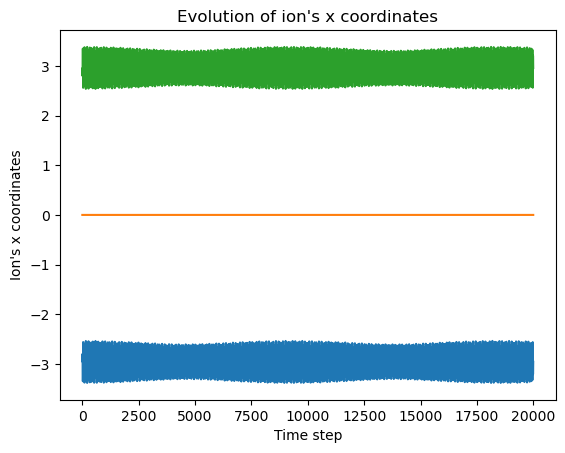

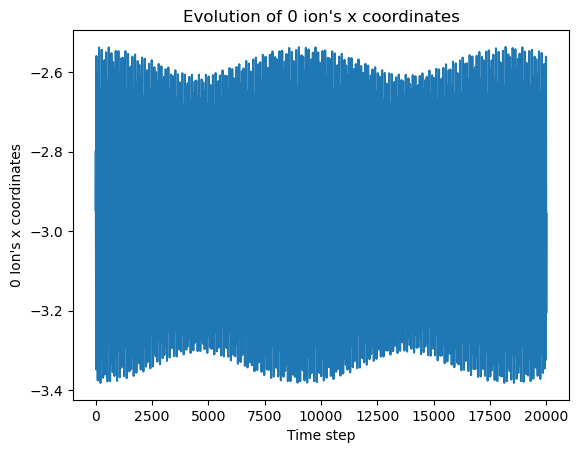

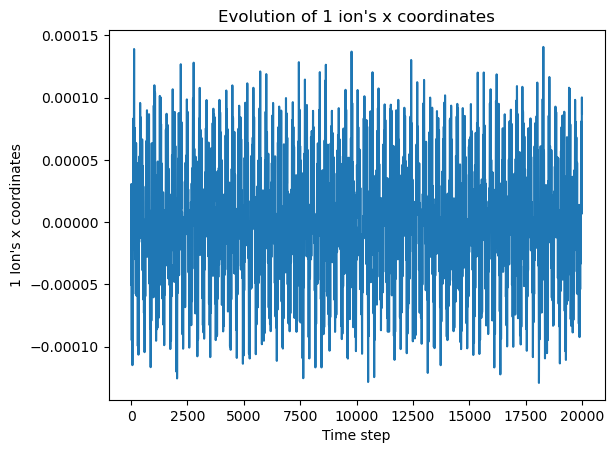

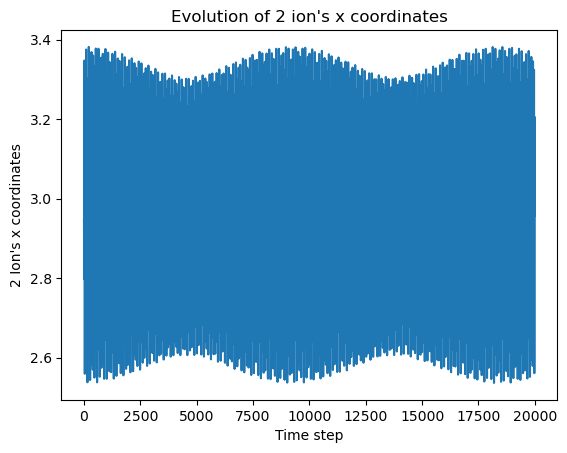

In [20]:
_, data = pl.readdump('2Dpositions_3.txt')
data *= 1e6

plt.figure()
for n in range(ion_number):
    plt.plot(data[::100, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

for n in range(ion_number):
    plt.figure()
    plt.plot(data[::100, n, 0])
    plt.title('Evolution of ' + str(n) +' ion\'s x coordinates')
    plt.xlabel('Time step')
    plt.ylabel(str(n) +' Ion\'s x coordinates')
    plt.show()

## Calculation of FFT frequencies

The following block performs FFT on normal mode coordinates.

In [21]:
x = data[:, :, 0]
y = data[:, :, 1]
z = data[:, :, 2]

T = data.shape[0]/(20*Omega) # simulation time
freqsfft = np.arange(data.shape[0])/T/1e6

normal_coordinates = []
for mode in modes:
    coord = np.zeros(data.shape[0])
    for i in range(ion_number):
        for j in range(3):
            coord = coord + mode[i + ion_number*j]*(data[:, i, j])
    normal_coordinates.append(coord)
normal_spectrum = []
for norm_coord in normal_coordinates:
    ion_spectrum = np.fft.fft(norm_coord)
    normal_spectrum.append(np.abs(ion_spectrum))

# Verification 

This block presents the frequencies of each mode, calculated with *sion.normal_modes()* function and by spectral analysis of crystal's motion. We observe, that the accuracy of calculation is >99% (except for modes 0 and 4, where accuracy >93%), and may be additionally improved by finding equilibrium positions more precisely. Additional peaks in the spectrum also corresponds to the coupling of the non-ideally calculated normal modes to each other.

Mode 0
Theoretical frequency: 0.17142714978522186
Theoretical mode vector: [ 3.01e-01 -6.01e-01  3.01e-01  4.78e-01 -4.48e-13 -4.78e-01 -2.72e-04
 -6.28e-15  2.72e-04]
Actual frequency: 0.18372024652180785
Frequency mismatch: -0.01229309673658599


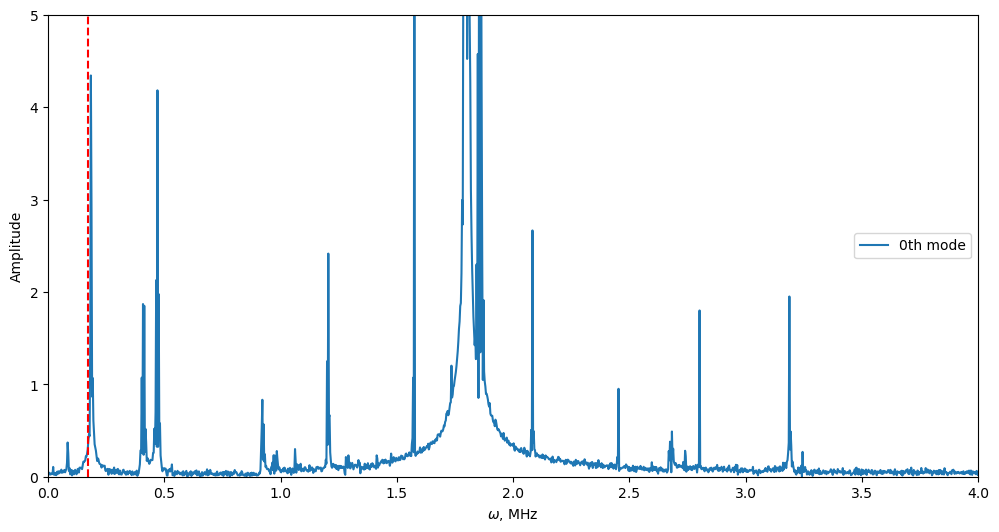

Mode 1
Theoretical frequency: 1.2260969903111478
Theoretical mode vector: [-5.77e-01 -5.77e-01 -5.77e-01  3.55e-16 -1.61e-16 -2.33e-16  3.29e-17
 -2.40e-17  9.06e-20]
Actual frequency: 1.2266028223661876
Frequency mismatch: -0.0005058320550397344


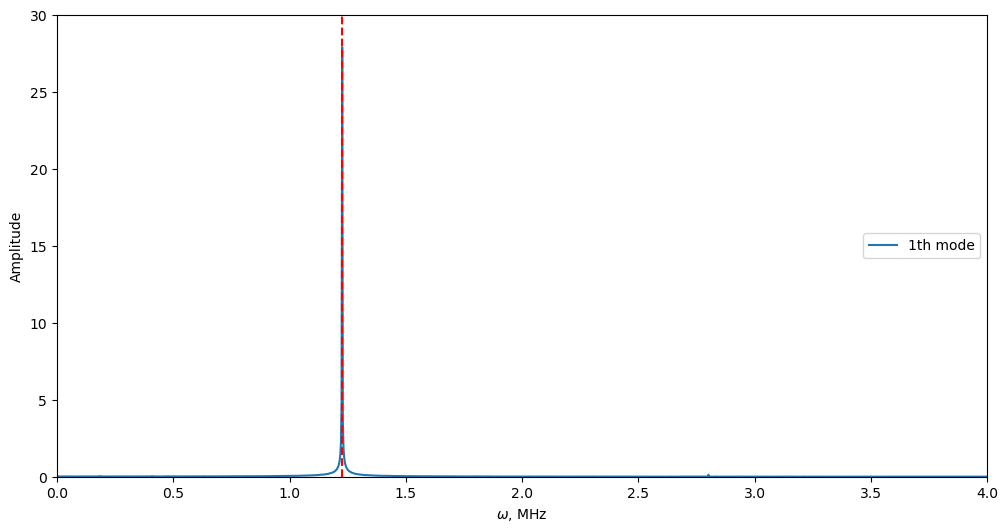

Mode 2
Theoretical frequency: 1.3879366428393396
Theoretical mode vector: [ 5.79e-15  1.52e-16 -5.71e-15  5.77e-01  5.77e-01  5.77e-01  2.45e-16
  8.07e-17 -1.56e-16]
Actual frequency: 1.3860071539071679
Frequency mismatch: 0.001929488932171708


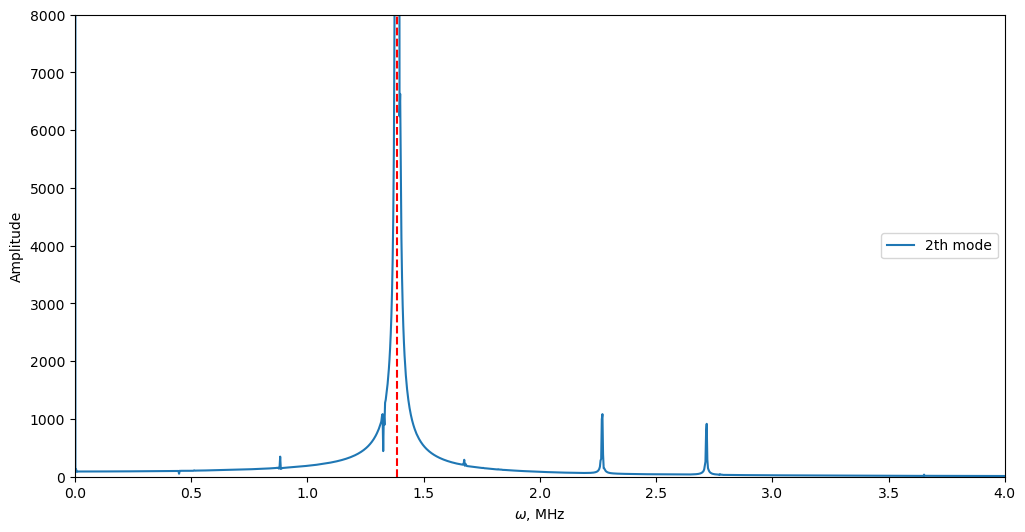

Mode 3
Theoretical frequency: 1.3992364988651194
Theoretical mode vector: [-5.51e-01  6.25e-12  5.51e-01 -2.56e-01  5.12e-01 -2.56e-01 -1.02e-03
  2.04e-03 -1.02e-03]
Actual frequency: 1.3914106905695742
Frequency mismatch: 0.007825808295545134


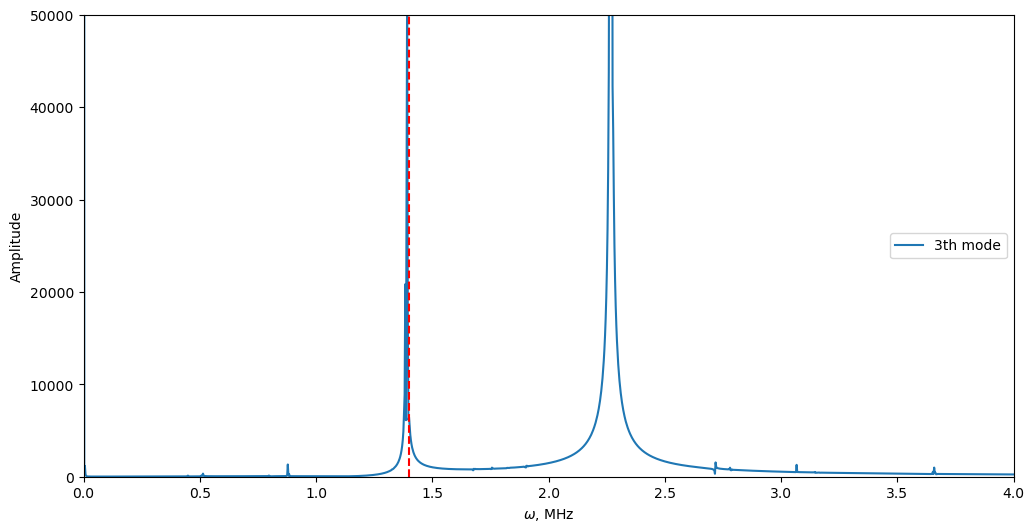

Mode 4
Theoretical frequency: 1.7738747802797759
Theoretical mode vector: [-2.76e-01  5.52e-01 -2.76e-01  5.21e-01 -2.85e-12 -5.21e-01  3.37e-03
 -4.37e-14 -3.37e-03]
Actual frequency: 1.7966759402500325
Frequency mismatch: -0.022801159970256668


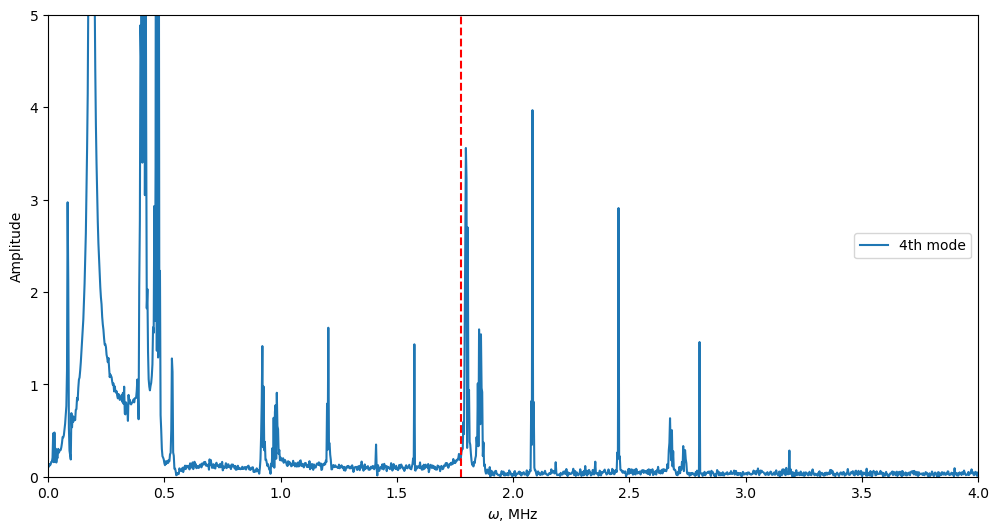

Mode 5
Theoretical frequency: 2.266393191740684
Theoretical mode vector: [ 4.43e-01 -2.98e-12 -4.43e-01 -3.18e-01  6.36e-01 -3.18e-01 -8.06e-03
  1.61e-02 -8.06e-03]
Actual frequency: 2.2694853982105676
Frequency mismatch: -0.0030922064698835072


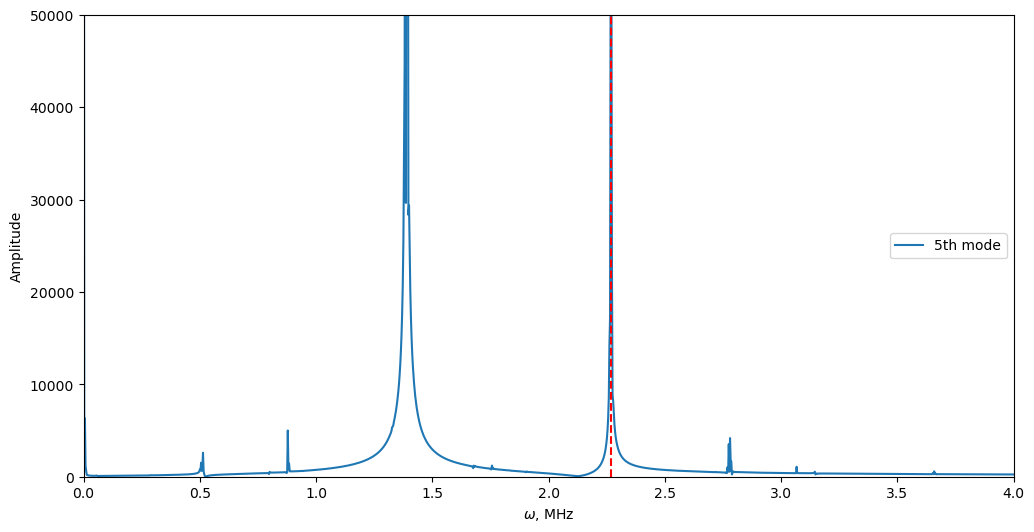

Mode 6
Theoretical frequency: 2.716128681465479
Theoretical mode vector: [ 7.38e-03 -1.24e-13 -7.38e-03 -6.91e-03  1.38e-02 -6.91e-03  4.08e-01
 -8.16e-01  4.08e-01]
Actual frequency: 2.717978941190275
Frequency mismatch: -0.0018502597247960217


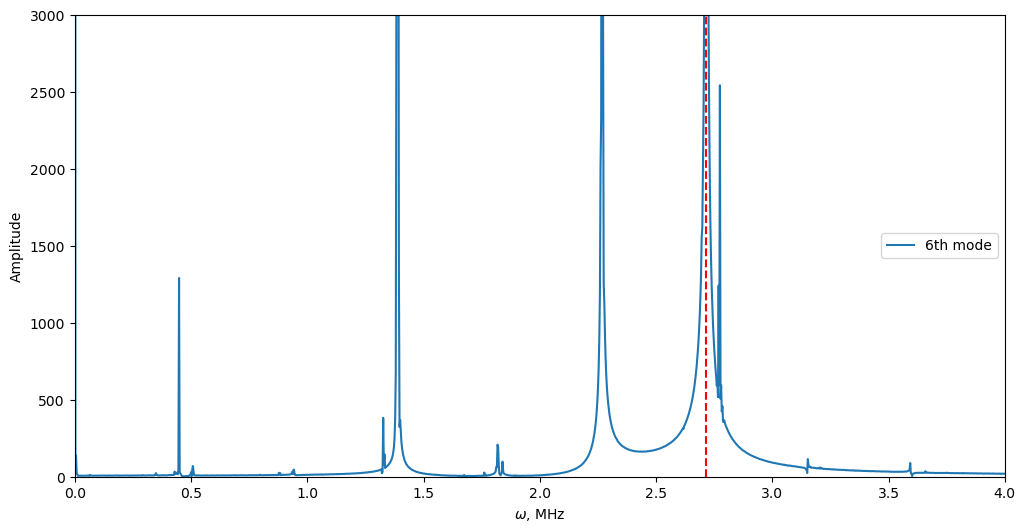

Mode 7
Theoretical frequency: 2.7914436787683203
Theoretical mode vector: [ 1.43e-03 -2.87e-03  1.43e-03 -2.30e-03 -1.29e-13  2.30e-03  7.07e-01
  1.59e-11 -7.07e-01]
Actual frequency: 2.8017337594575698
Frequency mismatch: -0.010290080689249415


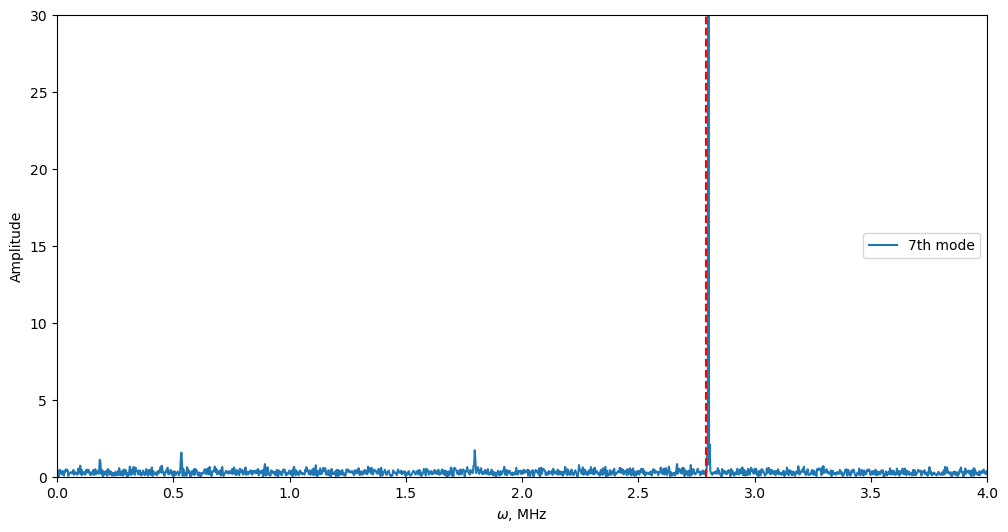

Mode 8
Theoretical frequency: 3.0479967848378373
Theoretical mode vector: [-1.55e-18 -8.58e-18  2.57e-17 -8.18e-18  1.67e-17  1.72e-17 -5.77e-01
 -5.77e-01 -5.77e-01]
Actual frequency: 3.0665070559154692
Frequency mismatch: -0.018510271077631923


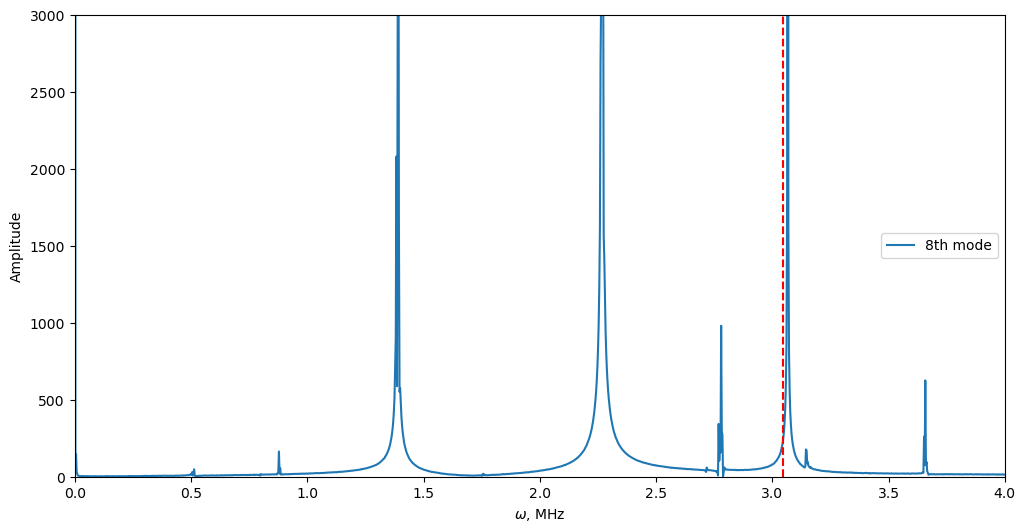

In [22]:
for n, ion_spectrum in enumerate(normal_spectrum):
    print('Mode',n)
    print('Theoretical frequency:',freqs[n]/1e6)
    print('Theoretical mode vector:',modes[n])
    act = freqsfft[int(freqs[n]*T)-50 + np.argmax(ion_spectrum[int(freqs[n]*T)-50:int(freqs[n]*T)+50])]
    print('Actual frequency:', act)
    print('Frequency mismatch:',freqs[n]/1e6 - act)
    
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = str(n)+'th mode')
    plt.axvline(freqs[n]/1e6, c='r', ls = '--')
    plt.legend(loc = 'right')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(0, 4)
    if n == 1 or n == 7:
        plt.ylim(0, 30)
    elif n == 6 or n == 8:
        plt.ylim(0, 3000)
    elif n == 0 or n == 4:
        plt.ylim(0, 5)
    elif n == 2:
        plt.ylim(0, 8000)
    else: 
        plt.ylim(0, 50000)
    plt.ylabel('Amplitude')
    plt.show()